# Download and tabulate AQUA equation of state

Originally available here: https://github.com/mnijh/AQUA

In [1]:
import os
import numpy as np
from thermotools import get_inpdir, get_gendir, empty_dir
from thermotools.util import download, unzip
from thermotools.plot import *
from scipy.interpolate import griddata

In [3]:
datdir = os.path.join(get_gendir(), "aqua", "dat")
empty_dir(datdir)
pltdir = os.path.join(get_gendir(), "aqua", "plt")
empty_dir(pltdir)
webdir = os.path.join(get_gendir(), "aqua", "web")
empty_dir(webdir)

First, we will download the data and unzip it

In [4]:
url      = "https://osf.io/download/uqrdx/"
zip_file = os.path.join(webdir, "aqua_rho_vs_pt.zip")

download(url, zip_file)
unzip(zip_file, webdir)

Download file from https://osf.io/download/uqrdx/


    Done
Unzipping /dataserver/users/formingworlds/nicholls/ThermoTools/generated/aqua/web/aqua_rho_vs_pt.zip
    Done


Read the data into memory

In [5]:
raw_file = os.path.join(webdir, "aqua_eos_pt_v1_0.dat")
data = np.loadtxt(raw_file, skiprows=19).T
tmp_raw = data[1]
prs_raw = np.log10(data[0])
rho_raw = np.log10(data[2])

print("    tmp: %+7.2f to %+.2f, %d points"%(np.amin(tmp_raw), np.amax(tmp_raw), len(tmp_raw)))
print("log prs: %+7.2f to %+.2f, %d points"%(np.amin(prs_raw), np.amax(prs_raw), len(prs_raw)))
print("log rho: %+7.2f to %+.2f, %d points"%(np.amin(rho_raw), np.amax(rho_raw), len(rho_raw)))

    tmp: +100.00 to +100000.00, 328993 points
log prs:   -1.00 to +14.60, 328993 points
log rho:   -9.44 to +5.00, 328993 points


Demonstrate interpolation at low resolution

Number of points = 2000


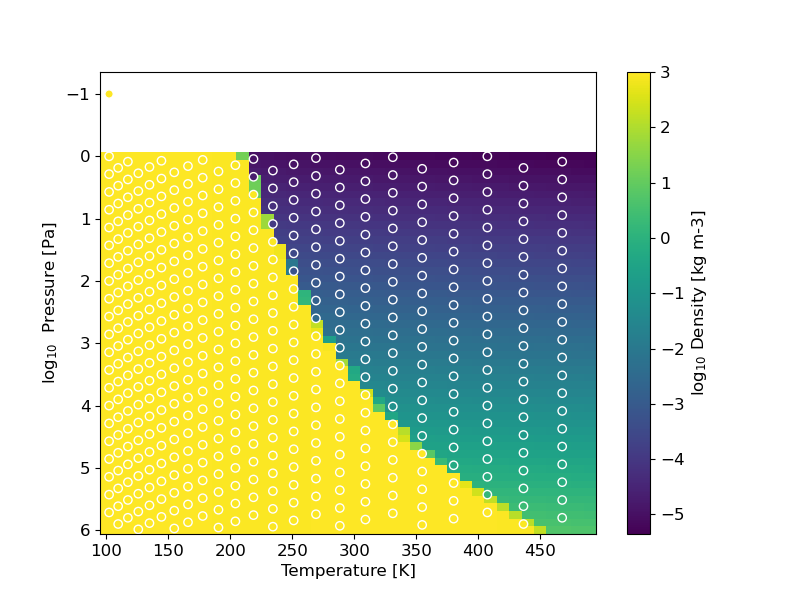

In [6]:
# target axes
t_eval = np.arange(  100,  500, 10.0)   # K
p_eval = np.linspace(0,   6,   50)     # log Pa
print("Number of points = %g"%(len(p_eval)*len(t_eval),))

# interpolate
ti,pi = np.meshgrid(t_eval,p_eval)
zi = griddata((tmp_raw,prs_raw),rho_raw,(ti,pi),method='linear', rescale=True)

# truncate and down-sample original data
s = 60
tmin, tmax = t_eval[0], t_eval[-1]
pmin, pmax = p_eval[0], p_eval[-1]
mask = np.argwhere( (tmin < tmp_raw) & (tmp_raw < tmax))
tmp_ref = tmp_raw[mask]
prs_ref = prs_raw[mask]
rho_ref = rho_raw[mask]
mask = np.argwhere( (pmin < prs_ref) & (prs_ref < pmax))[::s]
tmp_ref = tmp_ref[mask]
prs_ref = prs_ref[mask]
rho_ref = rho_ref[mask]

# plot
norm = mpl.colors.Normalize(vmin=np.amin(zi), vmax=np.amax(zi))
cmap = "viridis"
fig,ax = plt.subplots(1,1, figsize=(8,6))
sm = ax.pcolormesh(ti, pi, zi, norm=norm)
ax.scatter(tmp_ref, prs_ref, c=rho_ref, norm=norm, cmap=cmap, edgecolors='white')
ax.invert_yaxis()
ax.set(ylabel=r"log$_{10}$  Pressure [Pa]", xlabel="Temperature [K]")
fig.colorbar(sm, label=r"log$_{10}$ Density [kg m-3]")
plt.show()
fig.savefig(os.path.join(pltdir, "demo_lowres.png"), dpi=200, bbox_inches='tight')

High resolution calculation

In [7]:
t_eval = np.arange(  101,  4000, 0.8)   # K
p_eval = np.linspace(0,   10,    225)     # log Pa
print("Number of points = %.2e"%(len(p_eval)*len(t_eval),))

Number of points = 1.10e+06


In [8]:
ti,pi = np.meshgrid(t_eval,p_eval)
zi = griddata((tmp_raw,prs_raw),rho_raw,(ti,pi),method='linear',rescale=True)

In [9]:
print(zi)
print("Contains NaN: "+str(np.any(np.isnan(zi))))

[[ 2.96988659  2.96987572  2.96986462 ... -6.74312085 -6.74320715
  -6.74329346]
 [ 2.96988659  2.96987572  2.96986462 ... -6.69847578 -6.69856209
  -6.6986484 ]
 [ 2.96988659  2.96987572  2.96986462 ... -6.65383622 -6.65392253
  -6.65400883]
 ...
 [ 3.25863456  3.25862935  3.25862401 ...  3.0765041   3.0764805
   3.07645691]
 [ 3.26564225  3.26563738  3.26563242 ...  3.0940021   3.09398024
   3.09395838]
 [ 3.27301598  3.27301142  3.27300676 ...  3.11104791  3.11102729
   3.11100668]]
Contains NaN: False


In [10]:
print("Saving data")
X = np.array([ti.flat, pi.flat, zi.flat]).T
fpath = os.path.join(datdir, "H2O.csv")
np.savetxt(fpath, X, fmt="%.9e", header="T [K], log P [Pa], log rho [kg/m^3]", delimiter=',')
print("    Done")

Saving data
    Done


Making plot
    Done


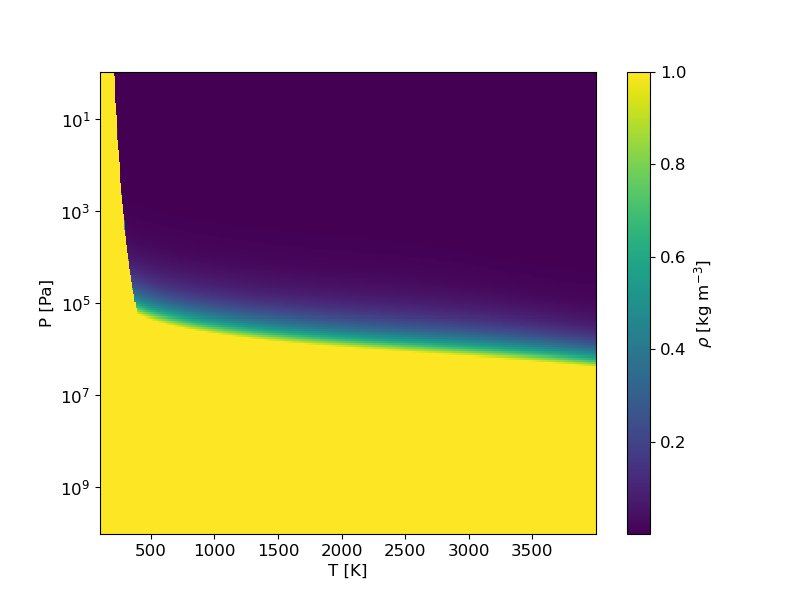

In [11]:
print("Making plot")

# plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.invert_yaxis()
ax.set_yscale('log')
ax.set_xlabel('T [K]')
ax.set_ylabel('P [Pa]')

R = 10**zi
im = ax.pcolormesh(ti, 10**pi, R, cmap='viridis', norm='linear', vmax=1)
fig.colorbar(im, label=r'$\rho$ [kg m$^{-3}$]')
fig.savefig(os.path.join(pltdir, "H2O_rho.png"), bbox_inches='tight', dpi=210)

print("    Done")